# <b><i><center><h2> Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')

# <b><i><center><h2> Helper Functions

## <b><i><center> Time Series Function (Will Plot time series graph)

In [23]:
def TimeSeries_graph(ts, model='additive', decomposition_plot=True):
    plt.style.use('dark_background')
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(ts, marker='o', linestyle='-', color='#1f78b4', label=ts.columns[0], alpha=0.8, markersize=3)
    plt.title("Time Series Plot", fontsize=14, fontweight='bold', color='white')
    plt.xlabel("Date", fontsize=10, color='white')
    plt.ylabel(ts.columns[0], fontsize=10, color='white')
    
    # Formatting axes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())
    plt.gcf().autofmt_xdate(rotation=45, ha='right')
    
    plt.grid(visible=True, which='major', color='gray', linestyle='--', alpha=0.3)
    plt.grid(visible=True, which='minor', color='lightgray', linestyle=':', alpha=0.2)
    plt.legend(loc='upper left', fontsize=10, facecolor='black', edgecolor='white')
    
    plt.tight_layout()
    plt.show()
    
    if decomposition_plot:
        # Seasonal decomposition
        decomposition = sm.tsa.seasonal_decompose(ts, model=model)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        resid = decomposition.resid
        observed = decomposition.observed

        # Decomposition plots
        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"{model.capitalize()} Decomposition of Time Series", fontsize=14, fontweight='bold', color='white')

        # Observed
        axes[0].plot(observed, color='#1f78b4', alpha=0.8)
        axes[0].set_title("Observed", fontsize=10, color='white')
        axes[0].grid(visible=True, linestyle='--', alpha=0.3)

        # Trend
        axes[1].plot(trend, color='#ff7f0e', alpha=0.8)
        axes[1].set_title("Trend", fontsize=10, color='white')
        axes[1].grid(visible=True, linestyle='--', alpha=0.3)

        # Seasonal
        axes[2].plot(seasonal, color='#2ca02c', alpha=0.8)
        axes[2].set_title("Seasonal", fontsize=10, color='white')
        axes[2].grid(visible=True, linestyle='--', alpha=0.3)

        # Residual
        axes[3].plot(resid, color='#d62728', alpha=0.8)
        axes[3].set_title("Residual", fontsize=10, color='white')
        axes[3].grid(visible=True, linestyle='--', alpha=0.3)

        for ax in axes:
            ax.set_ylabel("Values", fontsize=8, color='white')
            ax.tick_params(axis='x', colors='white', labelsize=8)
            ax.tick_params(axis='y', colors='white', labelsize=8)

        axes[3].set_xlabel("Time", fontsize=10, color='white')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


## <b><i><center> ARIMA Function: Future Prediction and Visualization

In [24]:
def ARIMA_model(original_series, stationary_series, train_ratio=0.8, p_range=range(0, 8), d_range=range(0, 8), q_range=range(0, 2)):
    sns.set_theme(style="darkgrid", context="talk")
    
    # Train-Test Split
    train_len = int(len(stationary_series) * train_ratio)
    train = stationary_series[:train_len]
    test = stationary_series[train_len:]

    mse_lst, rmse_lst, order_lst = [], [], []
    pdq_combinations = list(itertools.product(p_range, d_range, q_range))

    print("Please wait, it may take a few moments...")
    print("Searching for the best ARIMA model parameters...")

    for pdq in pdq_combinations:
        try:
            model = ARIMA(train, order=pdq).fit()
            pred = model.predict(start=len(train), end=len(stationary_series) - 1)

            # Metrics Calculations
            mse = mean_squared_error(test, pred)
            rmse = np.sqrt(mse)

            # Appending to Lists
            order_lst.append(pdq)
            mse_lst.append(mse)
            rmse_lst.append(rmse)

        except Exception as e:
            print(f"Error with ARIMA order {pdq}: {e}")
            continue

    # Create DataFrame for Results
    result_df = pd.DataFrame({
        'Mean Squared Error': mse_lst,
        'Root Mean Squared Error': rmse_lst,
    }, index=order_lst).sort_values(ascending=True, by='Mean Squared Error').head(1)

    best_params = result_df.index[0]
    
    # Final Model Training with Best Parameters
    final_model = ARIMA(original_series, order=best_params).fit()
    prediction = final_model.predict(start=1600, end=len(original_series) + 30)

    # Plot: Predictions on Original Series
    plt.figure(figsize=(14, 8))
    plt.plot(original_series, label="Original Data", color='#2ca02c', linestyle='-', alpha=0.7)
    plt.plot(prediction, label="Prediction", color='#d62728', linestyle='--', marker='o', alpha=0.8, markersize=4)
    plt.title("ARIMA Model: Predictions on Original Series", fontsize=18, fontweight='bold', color='white')
    plt.xlabel("Time", fontsize=14, color='white')
    plt.ylabel("Values", fontsize=14, color='white')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5, color='white')
    plt.tight_layout()
    plt.gca().set_facecolor('#111111')
    plt.gcf().set_facecolor('#111111')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.show()

    return result_df

## <b><i><center> ADF Function: Test for Stationarity in Time Series Data


In [25]:
def adf_test(series, max_diff=10, alpha=0.05):
    result_dict = {}
    for i in range(max_diff + 1):
        if i > 0:
            series = series.diff().dropna()

        result = adfuller(series)
        p_value = result[1]

        result_dict[f'Differencing Level {i}'] = {
            'ADF Statistic': result[0],
            'p-value': f"{p_value:.4e}",
            'Lags Used': result[2],
            'Number of Observations': result[3],
            'Stationary': "Yes" if p_value <= alpha else "No"
        }

        print(f"--- Differencing Level {i} ---")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4e}")
        if p_value <= alpha:
            print("Null Hypothesis rejected: Data is stationary")
            
            TimeSeries_graph(series, decomposition_plot=False)
            
            break
        else:
            print("Fail to reject Null Hypothesis: Data is not stationary")
    else:
        print("Series did not become stationary after maximum differencing")

    result_df = pd.DataFrame(result_dict).T
    
    result_df['p-value'] = result_df['p-value'].astype(str)
    return result_df, series

## <b><i><center> Loading Dataset

In [26]:
data = pd.read_csv("../Data/yahoo_stock.csv")
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


## <b><i><center> Data Preprocessing

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [28]:
data['Date'] = pd.to_datetime(data['Date'])

In [29]:
pd.api.types.is_datetime64_any_dtype(data['Date'])

True

In [33]:
# data.to_csv("Yahoo Stock Data (correct format).csv", index=False)
pd.read_csv("../Data/Yahoo Stock Data (correct format).csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [21]:
data.set_index(data['Date'], inplace=True)

In [9]:
ts = data[['Open']]

## <b><i><center> Time Series Plots

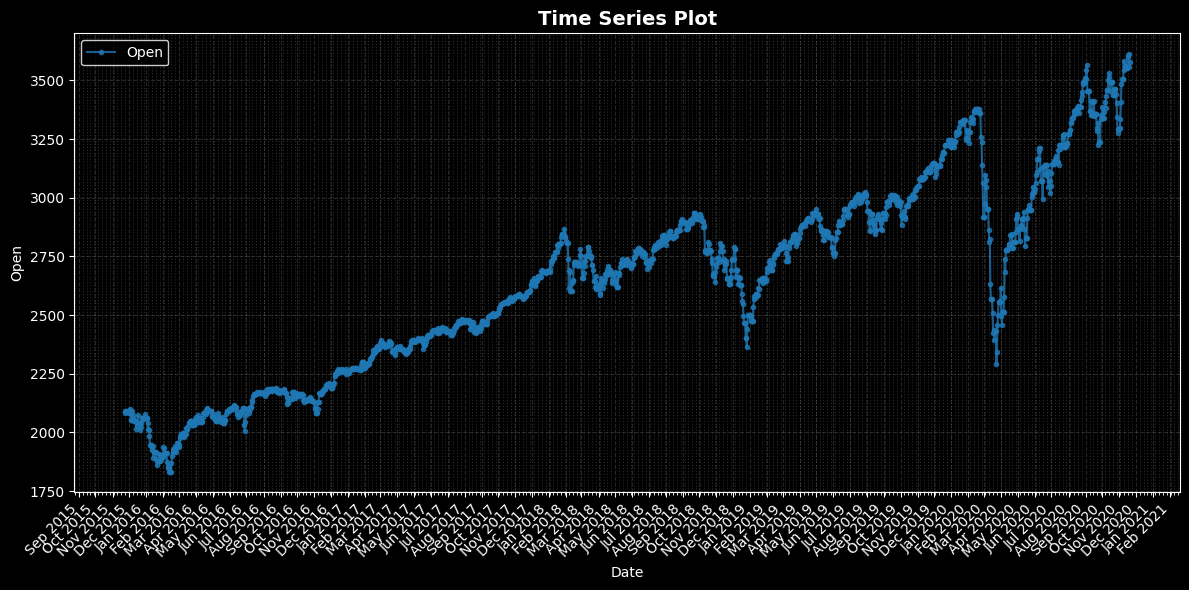

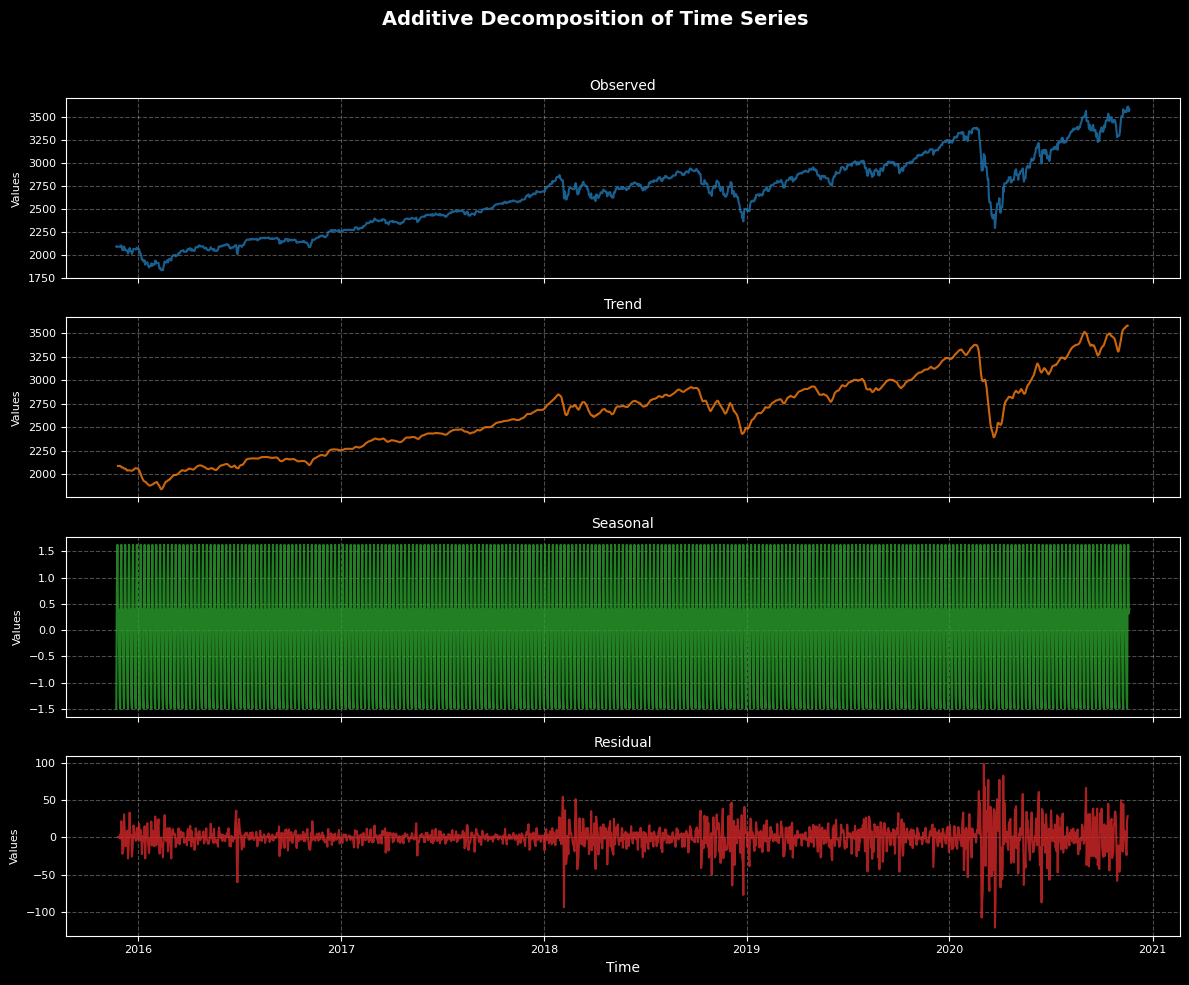

In [10]:
TimeSeries_graph(ts)

## <b><i><center> Stationarity Checking

--- Differencing Level 0 ---
ADF Statistic: -0.8539
p-value: 8.0279e-01
Fail to reject Null Hypothesis: Data is not stationary
--- Differencing Level 1 ---
ADF Statistic: -10.2932
p-value: 3.5258e-18
Null Hypothesis rejected: Data is stationary


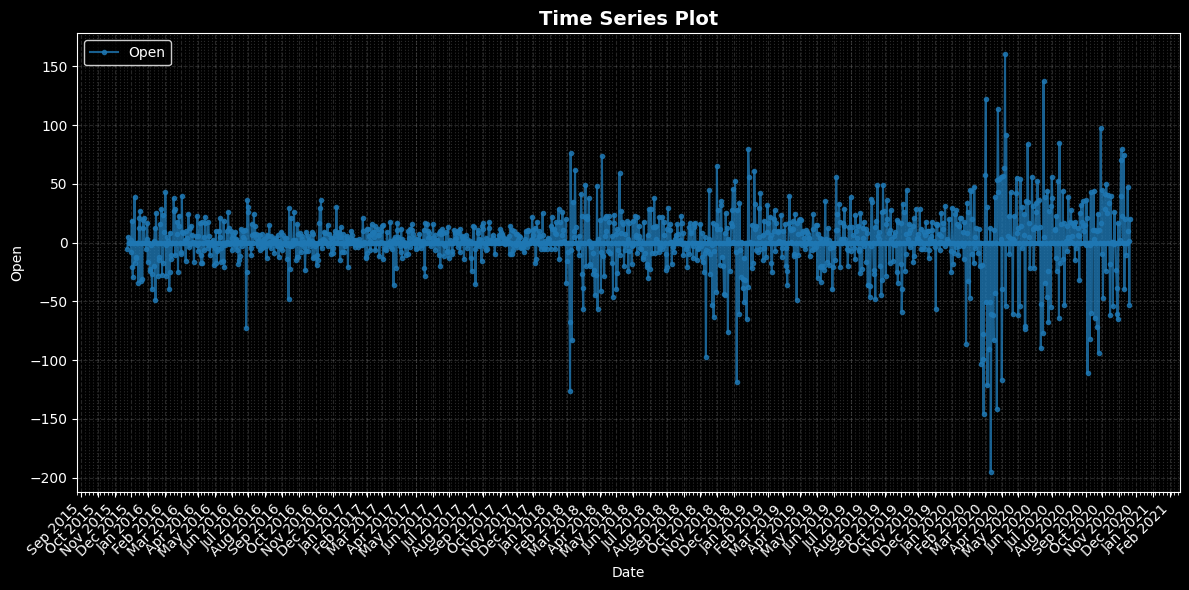

,ADF Statistic,p-value,Lags Used,Number of Observations,Stationary
Differencing Level 0,-0.853865,8.0279e-01,14,1810,No
Differencing Level 1,-10.293202,3.5258e-18,13,1810,Yes


In [11]:
adf_results, series = adf_test(ts)
adf_results

## <b><i><center> Prediction on Stationary data and Original Data

Please wait, it may take a few moments...
Searching for the best ARIMA model parameters...


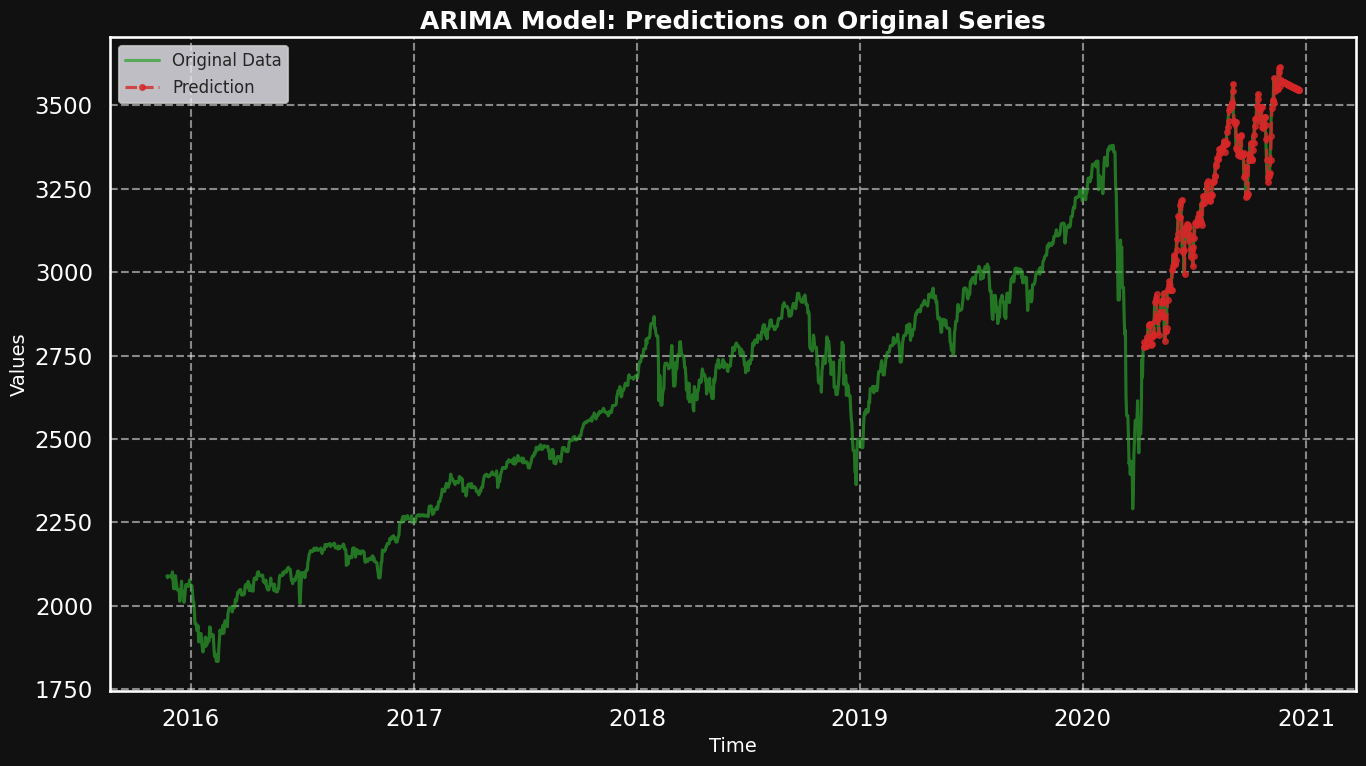

,Mean Squared Error,Root Mean Squared Error
"(6, 0, 0)",1493.878938,38.65073


In [12]:
model_result = ARIMA_model(original_series=data['Open'], stationary_series=series)
model_result